## FAKE NEWS EDA

in this notebook we are going to explore a dataset about news, in order to train a model being able to distinguish fake news from real ones


(WELFake) is a dataset of 72,134 news articles with 35,028 real and 37,106 fake news.

you can find the dataset on kaggle: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification

Dataset contains four columns: Serial number (starting from 0); Title (about the text news heading); Text (about the news content); and Label (0 = fake and 1 = real).

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Reading the data 

In [4]:
df = pd.read_csv('data\WELFake_Dataset.csv')
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


## Analysing Data

In [5]:
# chack for missing values and dataTypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [6]:
df.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

number of null values for text is too small, deleting them will not affect the data.

for missing titles, we can keep them

### class distribution

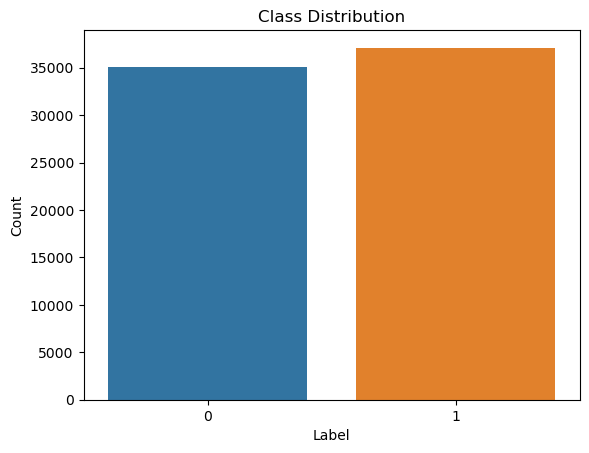

label
1    0.514404
0    0.485596
Name: proportion, dtype: float64


In [7]:
# check for class imbalance
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

print(df['label'].value_counts(normalize=True))

good thing, data is balanced

### Text lenght distribution

In [8]:
#text length distribution
df.loc[df['text'].notnull(), 'text'].apply(len).describe()

count     72095.000000
mean       3270.155878
std        3733.112756
min           1.000000
25%        1379.000000
50%        2425.000000
75%        4060.000000
max      142961.000000
Name: text, dtype: float64

most articles are around 3270 characters, known for articles to be quite long

high std --> high variability, some articles tend to be much longer then others

outliers, at least one article, max length 142961, which is not a normal length for an article 

(it can be an error or concatenation issue) --> ### inspect long entries

df.loc[df['text'].apply(len).idxmax(), 'text'][:1000]


some articles have length of 1, sign of missing or corrupted entries

df[df['text'].apply(len) <= 10][['text', 'label']].head(10)


In [9]:
#check for duplicates
df['text'].duplicated().sum()


9415

That’s quite high,  duplicates can bias the model if the same article appears multiple times.

For example, the model might “memorize” repeated articles instead of learning general patterns.


In [10]:
# average text length by class
df.groupby('label')['text'].apply(lambda x: x.str.len().mean())

label
0    3495.316690
1    3057.380824
Name: text, dtype: float64

c:\Users\lmokh phone\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


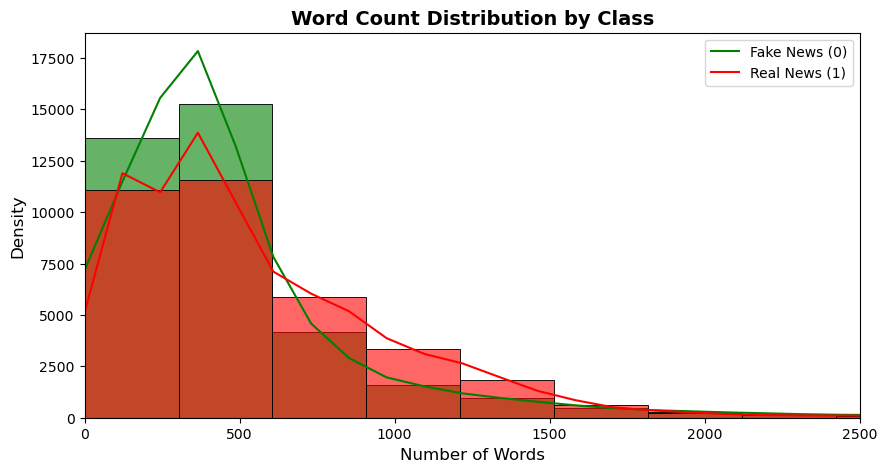

In [11]:
# Compute text lengths safely
df['text_length'] = df['text'].fillna('').apply(len)

df['word_count'] = df['text'].fillna('').apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(
    data=df, 
    x='word_count', 
    hue='label', 
    bins=80, 
    kde=True, 
    palette={0: 'red', 1: 'green'}, 
    alpha=0.6
)
plt.xlim(0, 2500)
plt.title('Word Count Distribution by Class', fontsize=14, weight='bold')
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(labels=['Fake News (0)', 'Real News (1)'])
plt.show()



the two classes are dense around 0-600 nb words (overlap),

but real news articals tend to have more words than fake news,

we also have a right skewed data

## calculate sentiment Score for each article

In [12]:
from textblob import TextBlob

In [15]:
texts = df['text'].fillna('').tolist()

In [19]:
scores = [TextBlob(t).sentiment.polarity for t in texts]

In [20]:
df['sentiment_blob'] = scores

In [21]:
df.head()

,Unnamed: 0,title,text,label,text_length,word_count,sentiment_blob
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,5049,871,0.033103
1,1,NaN,Did they post their votes for Hillary already?,1,46,8,0.000000
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,216,34,0.258929
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,8010,1321,0.113865
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,1916,329,0.056373


c:\Users\lmokh phone\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


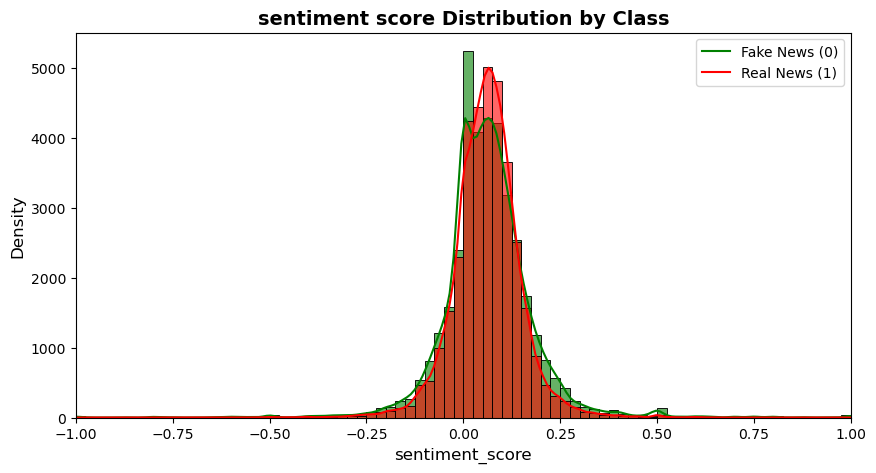

In [28]:
#plot the sentiment score per class
plt.figure(figsize=(10,5))
sns.histplot(
    data=df, 
    x='sentiment_blob', 
    hue='label', 
    bins=80, 
    kde=True, 
    palette={0: 'red', 1: 'green'}, 
    alpha=0.6
)
plt.xlim(-1, 1)
plt.title('sentiment score Distribution by Class', fontsize=14, weight='bold')
plt.xlabel('sentiment_score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(labels=['Fake News (0)', 'Real News (1)'])
plt.show()

as we can see, fake news tend to have higher sentiment score, even though they overlap between -0.5-0.15 close to neutral

but still fake news lead overall in sentiment score density, fake articles often use stronger emotional or exaggerated language (positive or negative) to attract attention or trigger reactions

so we should consider sentiment score during learning process

### Summary Of Insights

- real news articals tend to have more words than fake news
- fake news use strong emotional language
- data have 9415 duplicates texts, which can bias the learning
- we have 558 missing values for title, and 39 missing values for texts
- class labels are balanced, which simplifies training
- few extreme_length texts that worth checking